# Minimal encoding with VRP tutorials

### Contents
* [Introduction](#introduction)
* [Notations](#notations)
* [Minimal Encoding scheme](#scheme)
* [Implementation of minimal encoding](#min)
     * [ Quantum state and ansaz](#min-1)
     * [Cost function](#cost)
     * [Optimisation](#opt)
* [VRP](#vrp)
* [Solving VRP](#solvevrp)

$$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|} $$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

## Introduction <a class='anchor' id='introduction'></a>

This tutorials introduce you to an implementation of encoding scheme from the following papers : <br>
* [Qubit-efficient encoding schemes for binary optimisation problems](https://quantum-journal.org/papers/q-2021-05-04-454/)　(21 Apr 2021)
* [Qubit efficient quantum algorithms for the vehicle routing problem on quantum computers of the NISQ era](https://arxiv.org/abs/2306.08507)　(14 Jun 2023)

The main focus of this tutorial is to expload a possibility of minimal encoding which is a encoding scheme for QUBO problem. In these days there exists various encoding scheme for different problems (Machine learning, numerical optimization etc) and main purpose of these schemes are to encode classical problem into a quantum problem so it can be solve using quantum problem. Main motivation behind this is that there exists a possibility of quantum computing being more efficient than classical computing. <br>

However, current quantum devices (NISQ) known to have two main problems which are noise and limitted number qubits. 
To deal with these problems from software side, there are researches on error correction and error mitigation to deal with noise and on different encdoing methods to deal with limitation of number of qubits availble. <br> 
Minimal encoding belong to the second case. Specifically, to encode QUBO problem into quantum.

For instance QUBO can be solve using QAOA. In this case, QUBO will be encode into Ising Hamiltonian. <br> 
In this case, it requires the same number of qubits as classical variable. So if we have 10 variables in QUBO model, then we need 10 qubits in order to encode QUBO into Ising Hamiltonian. You may realise that with real world problems, this method we will reach the limit of current quantum device pretty quickly. <br> 
This also apply to other problems, as well.<br>

This tutorial introduce a minimal encoding scheme which aim to over come this limitation cause by limited number of qubits availble on current quantum divices.

## Notations

These are notations used in this tutorials.

* $n_c$ : classical bit
* $n_q$ : quantum bit
* $n_r$ : quantum register bit
* $n_a$ : quantum ancila bit
* $ l $ : number of layer for quantum circuit (ansaz)


## Minimal Encoding scheme <a class='anchor' id='scheme'></a>

With this minimal encoding scheme, the number of qubits require for classical bits is reduced. Specifically, it requires $\log_2 n_c$ quantum register bits and 1 quantum ancila bits. Therefore, the number of qubits it use is $$ n_q = \log_2 n_c + 1 $$

We will discuss only mathmatical formulas in this section. All implementations will be on the next section.

To encode QUBO problem, we use the following parameterised quantum state
$$ \tag{1} \ket{\psi_1 (\vec{\theta})} = \sum^{n_c}_{i=1} \beta_i (\vec{\theta})[a_i(\vec{\theta}) \ket{0}_a + b_i (\vec{\theta}) \ket{1}_a] \otimes \ket{\phi_i}_r $$

where
$$\{ \ket{\phi_i}_r \} \text{ : computational basis of regsister qubits} $$

$$\{ \ket{0}_a , \ket{1}_a \} \text{ : computational basis of ancilla qubit} $$

To define one-to-one correspondence between each of the $n_c$ classical variables $x_i$ in $\vec{x}$ and a unique basis state $\ket{\phi_i}_r$, the probability of the $i^{th}$ classical variable to have 0 or 1 can be determin as follow : 
$$ Pr(x_i = 1) = |b_i|^2  $$
$$ Pr(x_i = 0) = 1- |b_i|^2 = |a_i|^2 $$

Additionally,  $\beta_i(\vec{\theta})$ capture the likelihood of measuring each register state $\ket{\phi_i}$ and corresponding ancilla qubit

For example, to encoding the probability distribution over all solutions $\vec{x}$ of dimentions $n_c = 4$ which requires $n_r = 2$, mapping will be look like 
$$ \ket{\phi_1}_r = \ket{00}_r, \ket{\phi_2}_r = \ket{01}_r, \ket{\phi_3}_r = \ket{10}_r,\ket{\phi_4}_r = \ket{11}_r $$ and if $ \vec{x} = (1,0,0,1) $
then we have 
$$\ket{\psi_1} = (\ket{1}_a\ket{00}_r+\ket{0}_a\ket{01}_r + \ket{0}_a\ket{10}_r + \ket{1}_a\ket{11}_r)/2 $$

*This scheme can encode only distribution functions of statistically independent classical variables, which is a limitation of minimal encoding

As with standard VQAs, we define cost function as follow : 
$$\tag{2} C_1(\vec{\theta}) = \sum_{i,j=1}^{n_c} A_{ij} \frac{\langle \hat{P_i^1}\rangle_{\vec{\theta}} \langle \hat{P_i^j}\rangle_{\vec{\theta}}}{\langle \hat{P_i}\rangle_{\vec{\theta}}\langle \hat{P_j}\rangle_{\vec{\theta}}}(1-\delta_{ij}) + \sum_{i=1}^{n_c} A_{ii} \frac{\langle \hat{P}^1_i \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$

where : 
$$ \hat{P}_i = \ket{\phi_i}\bra{\phi_i}_r \text{ : projectors over registers, independent of the ancilla state }$$
$$ \hat{P}^1_i = \ket{1}\bra{1}_a \otimes \hat{P}_i \text{ : projectors over registers with ancilla being }\ket{1}_a$$

then, expectation values are expresses as follow : 
$$ \langle \hat{P}_i \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})} $$
given that 
$$ b_i(\vec{\theta}) = \langle \hat{P}_i^1 \rangle_{\vec{\theta}} / \langle \hat{P}_i \rangle_{\vec{\theta}} $$
For a detailed derivation of the cost function, please check the appendix of the paper.

This cost function is to minimise the parameters $ \vec{\theta} $. Global minimum of the cost function is the exact solution to minimize QUBO.

The highly entangled quantum state that minimize (6) : $\ket{\psi} = \sum_i \beta_i \ket{\sigma_i}_a \otimes \ket{\phi_i}$ with $\sigma = \{ 0,1 \}$ and corresponds unambiguously to the exact solution $\vec{x} = [\sigma_1, .... , \sigma_{n_c}]$ that minimize QUBO define by $A$. 

$C_1 (\vec{\theta})$ is only depends on the set of norm $\{ |b_i|^2 \}$, so measurements on computational basis is sufficient for estimation. <br>


The cost function cannot be reduce to a linear function of expectation values. That is why QUBO model of this encoding scheme cannot be describede with a suitable Hamiltonian. It means that we cannot use standfard Quantum optimization methods such as QAOA or VQA. 

So, we follow the following optimization procedure : 
1. Start with random starting point $\theta_{init}$.
2. Measure the quantum state in computation basis ($\{ 0, 1 \}$)
3. Feed result to classical optimizer which update parameter $\theta_{new}$
4. After the function is minimzed, with the final quantum state $\ket{\psi(\vec{\theta}_{opt})}$, a set of solutions $\{ \vec{x} \}$ with value $C_x = xAx$ are obtained by sampleing each variable independently follwing $ Pr(x_i = 1) = |b_i|^2 $

## Implementation of minimal encoding <a class='anchor' id='min'></a>

In this section, we will see how to implement each part of minimal encoding with Python. 
1. Quantum state and ansaz (parameterised quantum circuit) 
2. Cost function 
3. Optimization procedure

### Quantum state and ansaz <a class='anchor' id='min-1'></a>

First, we import all necessary libraries.

In [24]:
import qiskit as qk
from qiskit import QuantumRegister, AncillaRegister , QuantumCircuit
from qiskit.circuit import  ParameterVector

from math import pi
import numpy as np

The initial quantum state (1) is produced by applying parameterized unitary evolution to initial product state $\ket{\psi_0}$ which can be express as follow : 

$$ \ket{\psi_1(\vec{\theta})} = \hat{U_1}(\vec{\theta})\ket{\psi_0} $$ 

This can be express as hardware efficient quantum circuit, and a single layer of this circuit is ... 

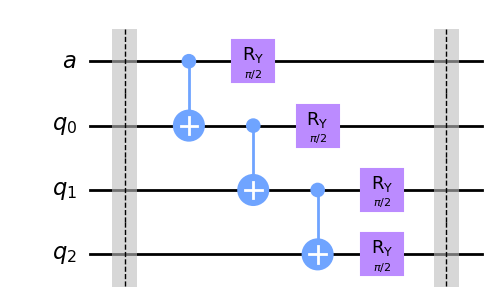

In [25]:
qreg_q = QuantumRegister(3, 'q')
areg_a = AncillaRegister(1, 'a')

circuit = QuantumCircuit(areg_a, qreg_q)
circuit.barrier()
circuit.cx(areg_a[0], qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ry(pi / 2, areg_a[0])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(pi / 2, qreg_q[0])
circuit.ry(pi / 2, qreg_q[1])
circuit.ry(pi / 2, qreg_q[2])
circuit.barrier()


circuit.draw(output='mpl')

There is no specific number of layer specified for this encoding scheme, so you can set it to any number. However, if you increase the number of layer, it increases the number variables thus it increase the number of computations for every iteration of optimization. 4 is good number of layer to start with. 

To construct the ansaz circuit, first we need to define the number of qubits ($n_r + n_a$) which is based on the problem and the number of layer. 

In [26]:
#example
nr = 3
na = 1
nq = 4
l = 4

Then we generate parameters with random numbers.

In [27]:
def init_parameter(nq:int , l:int):
    #initialize a parameters
    parameters = ParameterVector('θ', nq*l)
    #create a dictionary of parameters with random values and return it
    theta =  {parameter: np.random.random() for parameter in parameters}
    return parameters, theta

We now generate a parameterized circuit (ansaz). Do not forget to apply Hadmard gate as a first step before adding layers.

In [28]:
def generate_circuit(nr:int, na:int, l:int, parameters:np.array)->qk.circuit.quantumcircuit.QuantumCircuit:
    #define number of qubits
    nq = nr + na
    qreg_q = QuantumRegister(nr, 'q')
    areg_a = AncillaRegister(na, 'a')
    circuit = QuantumCircuit(areg_a, qreg_q)

    #add H gate for each qubit
    circuit.h(areg_a[0])
    for i in range(0,nr):
        circuit.h(qreg_q[i])
    circuit.barrier()
  
    #add layers which consist of CNOT and Ry gate
    for j in range(0,l):
        #CNOT
        # circuit.cx(qreg_q[0],areg_a[0])
        circuit.cx(areg_a[0],qreg_q[0])
        for i in range(nr):
            if i != 0:
                # circuit.cx(qreg_q[i],qreg_q[i-1]) 
                circuit.cx(qreg_q[i-1],qreg_q[i]) 

        #Ry
        for i in range(nq):
            if i == 0:
                circuit.ry(parameters[nq*j+i], areg_a[i])
            else:
                circuit.ry(parameters[nq*j+i], qreg_q[i-1])  
        circuit.barrier()
    return circuit

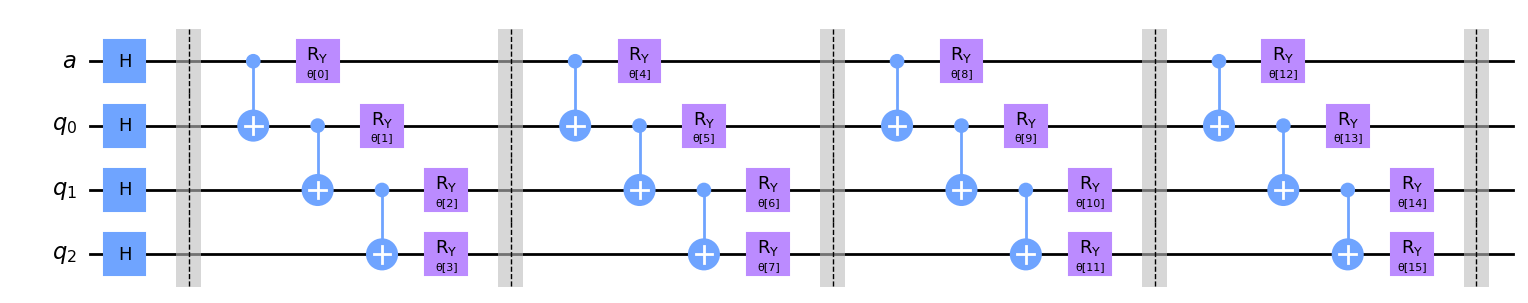

In [30]:
parameters, theta = init_parameter(nq, l)
circuit = generate_circuit(nr, na, l, parameters)
circuit.draw(output='mpl')

### Cost function <a class='anchor' id='cost'></a>

Recall the cost function : 
$$\tag{2} C_1(\vec{\theta}) = \sum_{i,j=1}^{n_c} A_{ij} \frac{\langle \hat{P_i^1}\rangle_{\vec{\theta}} \langle \hat{P_i^j}\rangle_{\vec{\theta}}}{\langle \hat{P_i}\rangle_{\vec{\theta}}\langle \hat{P_j}\rangle_{\vec{\theta}}}(1-\delta_{ij}) + \sum_{i=1}^{n_c} A_{ii} \frac{\langle \hat{P}^1_i \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$

Summation can be express using nested for loop, and setting each expectation values as $P$ and $P^1$ we can easily write a function as follow : 

In [32]:
def init_cost_function(A:np.ndarray, nc:int):
    #define cost function
    def cost_function(P1:np.array, P:np.array)->float:
        # first sum of cost function 
        first_sum = 0
        for i in range(nc):
            for j in range(nc):
                if i != j:
                    # first_sum += A[i][j]*(P1[i]*P1[j]/P[i]*P[j])
                    first_sum += A[i][j]*(P1[i]/P[i])*(P1[j]/P[j])
                # else:
                #     first_sum += A[i][i]*(P1[i]/P[i])
        # second sum of cost function 
        second_sum = 0
        for i in range(nc):
            second_sum += A[i][i]*(P1[i]/P[i])

        result = first_sum + second_sum
        return  result
    
    return cost_function

Where $A$ is a real symetric matrix from QUBO. <br> 
We define function inside another function just so we don't have to pass $A$ every time we compute cost function.

We talk about how to compute expectation value on the next section.

### Optimisation <a class='anchor' id='opt'></a>